**Gradient-Boosting Tree Algorithm  Model**


Running Non-Parallel Version
Training Time: 2.5582826137542725
Final Test MSE: 1246.6167626018087


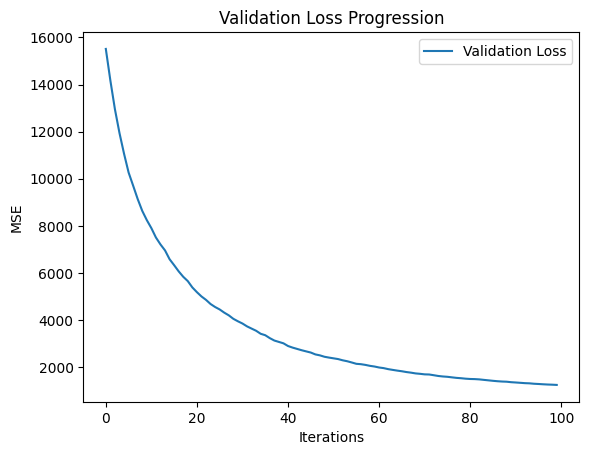

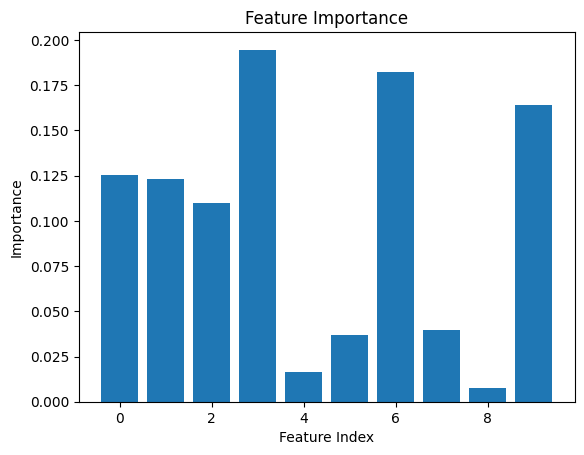


Running Parallel Version
Training Time: 8.086403608322144
Final Test MSE: 1246.6167626018087


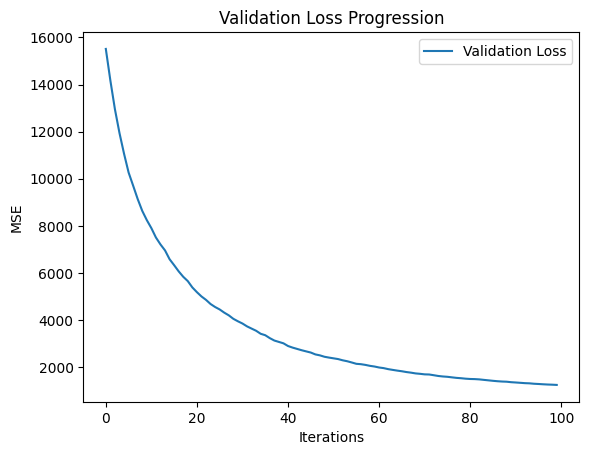

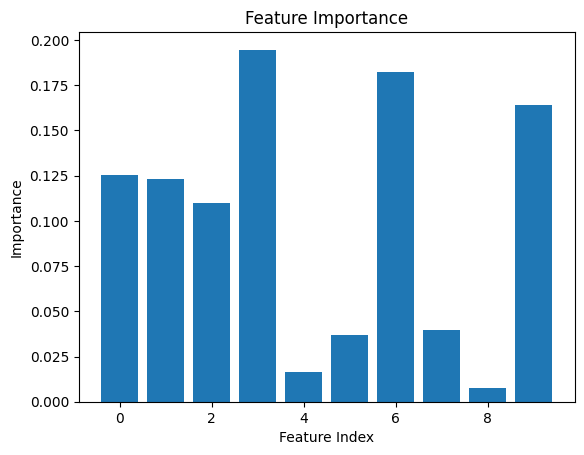

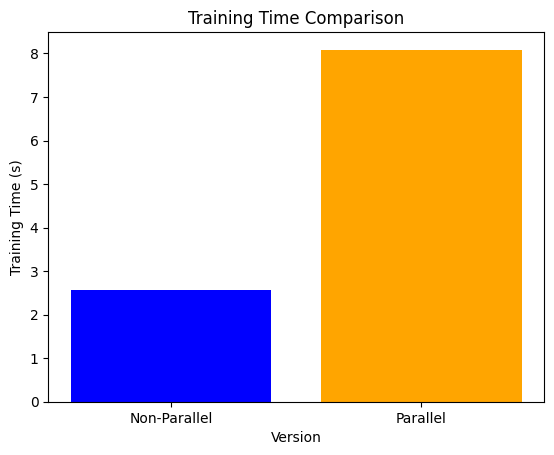


Benchmark Results:
Non-Parallel - Time: 2.56s, MSE: 1246.6168
Parallel     - Time: 8.09s, MSE: 1246.6168


In [14]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
from scipy.sparse import issparse
import time
import matplotlib.pyplot as plt


class GradientBoostingBase:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, loss_function="mse",
                 custom_loss=None, random_state=None, early_stopping_rounds=None, verbose=0, n_jobs=1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.loss_function = loss_function
        self.custom_loss = custom_loss
        self.random_state = random_state
        self.early_stopping_rounds = early_stopping_rounds
        self.verbose = verbose
        self.n_jobs = n_jobs
        self.trees = []
        self.initial_prediction = None
        self.best_iteration = None
        self.validation_loss = []  # Store validation loss for visualization

    def _initialize(self, y):
        if self.loss_function == "mse":
            return np.mean(y)
        elif self.loss_function == "logloss":
            p = np.clip(np.mean(y), 1e-15, 1 - 1e-15)
            return np.log(p / (1 - p))
        elif self.custom_loss and "init" in self.custom_loss:
            return self.custom_loss["init"](y)
        else:
            raise ValueError("Unsupported or custom loss function must provide 'init'.")

    def _negative_gradient(self, y, pred):
        if self.loss_function == "mse":
            return y - pred
        elif self.loss_function == "logloss":
            p = 1 / (1 + np.exp(-pred))
            return y - p
        elif self.custom_loss and "grad" in self.custom_loss:
            return self.custom_loss["grad"](y, pred)
        else:
            raise ValueError("Unsupported or custom loss function must provide 'grad'.")

    def _update_prediction(self, pred, new_tree_pred):
        return pred + self.learning_rate * new_tree_pred

    def fit(self, X, y, X_val=None, y_val=None):
        if issparse(X):
            X = X.tocsc()

        np.random.seed(self.random_state)
        self.trees = []
        self.initial_prediction = self._initialize(y)
        pred = np.full(y.shape, self.initial_prediction)
        best_val_loss = float('inf')
        stopping_round = 0

        for i in range(self.n_estimators):
            residuals = self._negative_gradient(y, pred)

            if self.n_jobs != 1:
                # Parallel tree fitting
                trees = Parallel(n_jobs=self.n_jobs)(
                    delayed(self._fit_single_tree)(X, residuals)
                    for _ in range(1)
                )
                tree = trees[0]
            else:
                # Sequential tree fitting
                tree = self._fit_single_tree(X, residuals)

            self.trees.append(tree)
            pred = self._update_prediction(pred, tree.predict(X))

            # Early stopping with validation set
            if X_val is not None and y_val is not None:
                val_pred = self.predict(X_val)
                val_loss = mean_squared_error(y_val, val_pred)
                self.validation_loss.append(val_loss)
                if self.verbose > 0:
                    print(f"Iteration {i+1}, Validation MSE: {val_loss:.4f}")
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    stopping_round = 0
                else:
                    stopping_round += 1
                if self.early_stopping_rounds and stopping_round >= self.early_stopping_rounds:
                    if self.verbose > 0:
                        print(f"Early stopping at iteration {i+1}")
                    self.best_iteration = i + 1
                    break

    def _fit_single_tree(self, X, residuals):
        tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
        tree.fit(X, residuals)
        return tree

    def predict(self, X):
        if issparse(X):
            X = X.tocsc()
        pred = np.full(X.shape[0], self.initial_prediction)
        for i, tree in enumerate(self.trees):
            if self.best_iteration and i >= self.best_iteration:
                break
            pred = self._update_prediction(pred, tree.predict(X))
        if self.loss_function == "logloss":
            return 1 / (1 + np.exp(-pred))
        return pred


class GradientBoostingRegressor(GradientBoostingBase):
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, loss_function="mse",
                 custom_loss=None, random_state=None, early_stopping_rounds=None, verbose=0, n_jobs=1):
        super().__init__(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth,
                         loss_function=loss_function, custom_loss=custom_loss, random_state=random_state,
                         early_stopping_rounds=early_stopping_rounds, verbose=verbose, n_jobs=n_jobs)


# Benchmarking and Visualization
def benchmark_training(parallel=False):
    print("\nRunning", "Parallel" if parallel else "Non-Parallel", "Version")

    # Generate and preprocess data
    X, y = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train model
    model = GradientBoostingRegressor(
        n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42,
        early_stopping_rounds=10, verbose=0, n_jobs=-1 if parallel else 1
    )

    start_time = time.time()
    model.fit(X_train, y_train, X_val=X_test, y_val=y_test)
    training_time = time.time() - start_time

    # Evaluate
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)

    print("Training Time:", training_time)
    print("Final Test MSE:", mse)

    # Plot Validation Loss
    plt.plot(model.validation_loss, label="Validation Loss")
    plt.xlabel("Iterations")
    plt.ylabel("MSE")
    plt.title("Validation Loss Progression")
    plt.legend()
    plt.show()

    # Plot Feature Importance
    feature_importance = np.mean([tree.feature_importances_ for tree in model.trees], axis=0)
    plt.bar(range(X.shape[1]), feature_importance)
    plt.xlabel("Feature Index")
    plt.ylabel("Importance")
    plt.title("Feature Importance")
    plt.show()

    return training_time, mse


if __name__ == "__main__":
    # Benchmark Non-Parallel Version
    non_parallel_time, non_parallel_mse = benchmark_training(parallel=False)

    # Benchmark Parallel Version
    parallel_time, parallel_mse = benchmark_training(parallel=True)

    # Comparison Results
    times = [non_parallel_time, parallel_time]
    labels = ["Non-Parallel", "Parallel"]
    plt.bar(labels, times, color=["blue", "orange"])
    plt.xlabel("Version")
    plt.ylabel("Training Time (s)")
    plt.title("Training Time Comparison")
    plt.show()

    print("\nBenchmark Results:")
    print(f"Non-Parallel - Time: {non_parallel_time:.2f}s, MSE: {non_parallel_mse:.4f}")
    print(f"Parallel     - Time: {parallel_time:.2f}s, MSE: {parallel_mse:.4f}")
